# YouTube Data API v3 - Mapping Corridor Digital's Network

### Python Libraries

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

## Custom modules

In [2]:
#import config # api_key is stored in config.py
import youtube_requests # Functions for making youtube_requests
import data_processing # Functions for data processing
import network_graphs # Functions for creating a network graph

Run autoloader to automatically reimport custom modules

In [3]:
%load_ext autoreload

%autoreload 1

%aimport network_graphs
%aimport youtube_requests
%aimport data_processing

## Create a list of channels to graph network

Here we are graphing Corridor, Corridor Crew, Corridor Cast, Node, and the Guilletine Channel. These are all channels related to the [Corridor Digital](https://www.youtube.com/user/CorridorDigital) production studio.

In [4]:
NBC_AND_FOX = ['UCeY0bbntWzzVIaj2z3QigXg', # NBC
              'UCXIJgqnII2ZOINSWNOGFThA'] # Fox

In [5]:
CORRIDOR_FIVE = ['UCNSeDrWRGxx5p2l3tj7RWQw',
                'UCsn6cjffsvyOZCZxvGoJxGg',
                'UCSpFnDQr88xCZ80N-X7t0nQ',
                'UCI4Wh0EQPjGx2jJLjmTsFBQ',
                'UCb8ewylk7d2M_1dLGEiFmuQ']

# Youtube Channel Details by Network

In [6]:
%%time
# Get a list of dictionaries, where each dictionary represents details for a specific channel
CHANNELS_DETAILS_ITEMS_LIST = youtube_requests.youtube_channel_details_by_network(
    NBC_AND_FOX, 3)
#CORRIDOR_FIVE
# Graph the network of channels
G = network_graphs.create_nx_graph(CHANNELS_DETAILS_ITEMS_LIST, True)

# Extract a columnar list of channel details
CHANNELS_DETAILS_LIST = data_processing.extract_channel_details(CHANNELS_DETAILS_ITEMS_LIST)

# Create a dataframe
DF = data_processing.create_df_from_details_list(CHANNELS_DETAILS_LIST)

# Graph G using matplotlib - gets messy with lots of data
#network_graphs.graph_nx_graph(G)

Channel_details_by_network
Have not seen this list, issuing request and caching.
2
13 total neighbors; 0 out of 2 channels do not feature channels
13
71 total neighbors; 2 out of 13 channels do not feature channels
50
59
137 total neighbors; 0 out of 59 channels do not feature channels
50
86
Time elapsed create graph:  0.0042999999999997485
Time elapsed channelId list:  5.8000000000113516e-05
Time elapsed determine position:  1.2429830000000006
Time elapsed Setting Attributes:  0.0011440000000000339
CPU times: user 1.62 s, sys: 72.6 ms, total: 1.69 s
Wall time: 8.45 s


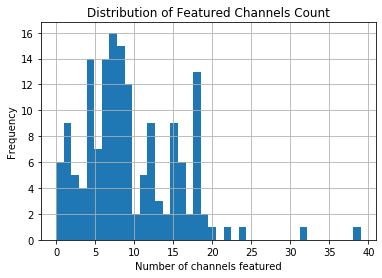

In [7]:
DF.hist(column='outDegree', bins=40)
plt.title(label='Distribution of Featured Channels Count')
plt.xlabel(xlabel='Number of channels featured')
plt.ylabel(ylabel='Frequency');

Here we see most channels do not feature more than 10 other channels on their profile pages. Some feature a lot more, with one as an outlier featuring 40 other channels.

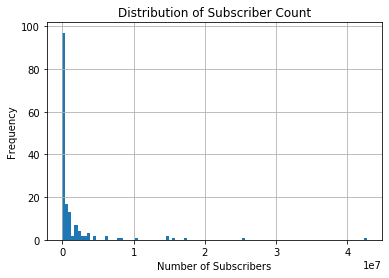

In [8]:
DF.hist(column = 'subscribers', bins=100)
plt.title(label='Distribution of Subscriber Count')
plt.xlabel(xlabel='Number of Subscribers')
plt.ylabel(ylabel='Frequency');

Here we see that the distribution of subscriber counts for each channel is not limited to highly subscribed channels. In fact there are a lot of channels with less than 100k subscribers.

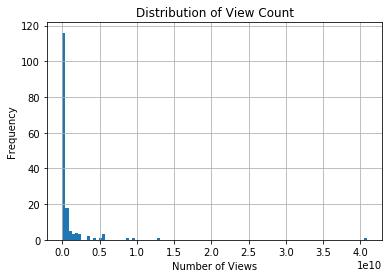

In [9]:
DF.hist(column = 'views', bins=100)
plt.title(label='Distribution of View Count')
plt.xlabel(xlabel='Number of Views')
plt.ylabel(ylabel='Frequency');

Here we see the same thing as with subscriber count; there are a lot of channels that do not have a lot of views, even though we are coming from a network that has some channels that have over 1 billion views.

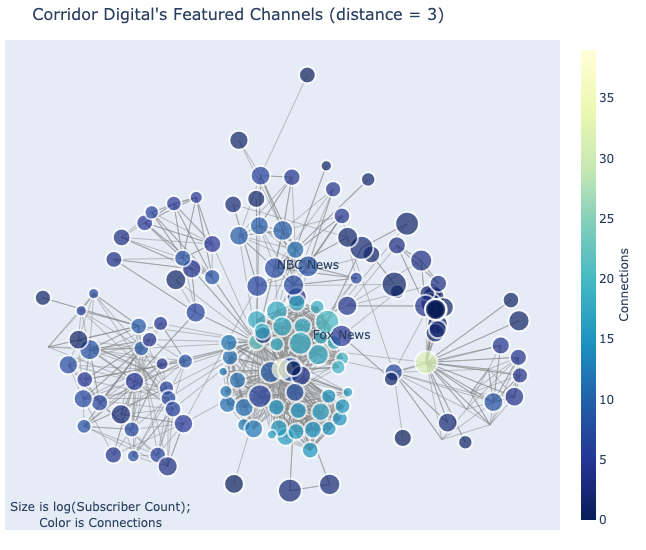

In [10]:
fig = network_graphs.plotly_network_graph(G, "Connections", "Corridor Digital's Featured Channels (distance = 3)")
fig # Interactive version of the figure for notebooks

Here we see Corridor Digital's network at a distance of 3 or less away. The colors represent the number of outgoing connections from each node. Those with high values (yellow) feature more channels than those with lower values (blue).

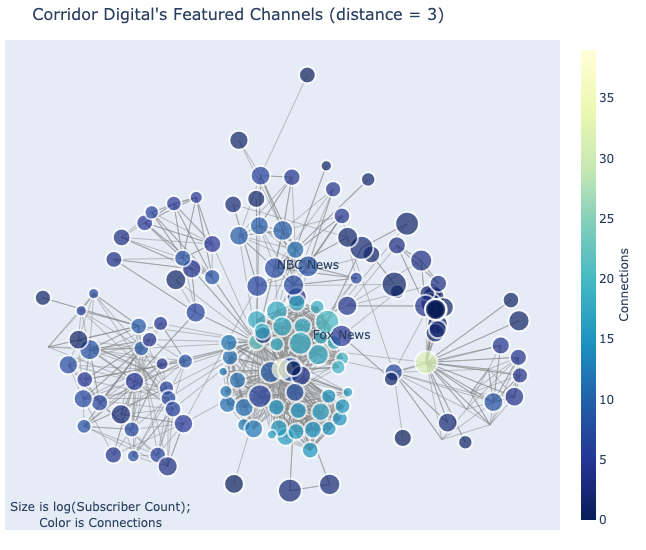

In [11]:
fig

In [12]:
fig.write_image('images/nbcfox-3.png')

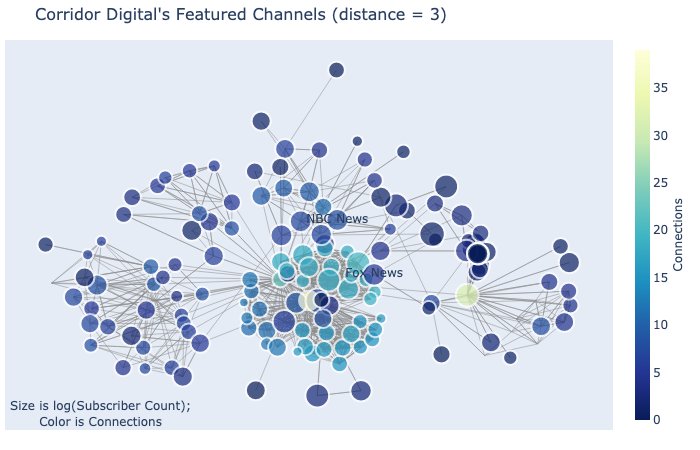

In [13]:
fig.show("png")

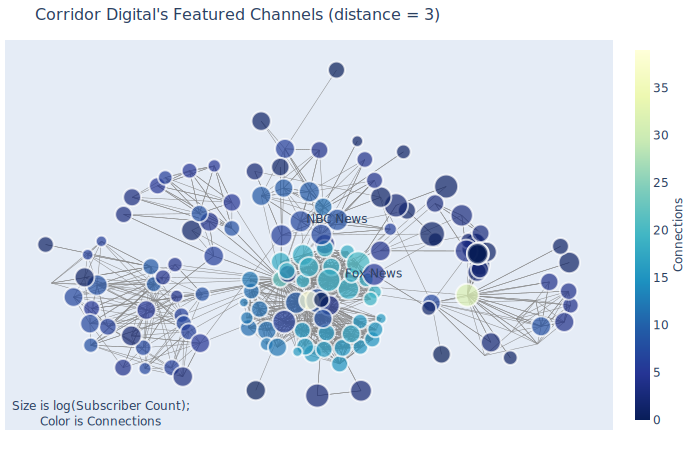

In [14]:
# Show figure for GitHub
fig.show("svg")

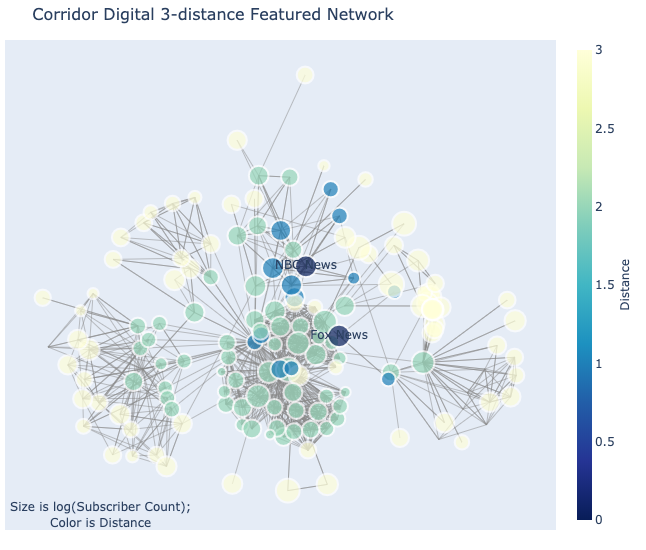

In [15]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network')
fig

Here we again see Corridor Digital's network at a distance of 3 or less. In this case the colors represent the distance from our channel origins. Blue represents origin, ligh blue represents 1 channels away, green represents 2 channels away, and yellow represents 3 channels away.

It could be possible for a channel that is 3 channels away from Corridor Digital to then reference one of the Corridor channels back, but this would not change their distance, as going *from* a Corridor Channel *to* that other channel, required three steps to crawl to that channel. Directionality in this case matters.

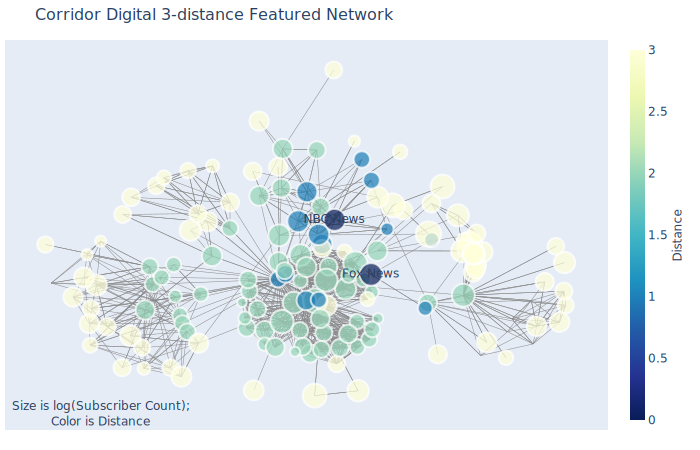

In [16]:
# Show figure for GitHub
fig.show("svg")

## Page Rank, In-Degree centrality, Betweeness Centrality, and In-Degree value

In [17]:
page_rank_series = pd.Series(data = network_graphs.simple_page_rank(G), index = list(G.nodes().keys()))
DF['page_rank'] = DF['id'].map(lambda x:page_rank_series[x])

betweenness_dict = nx.betweenness_centrality(G)
DF['betweenness_centrality'] = DF['id'].map(lambda x:betweenness_dict[x])

in_degree_centrality_dict = nx.in_degree_centrality(G)
DF['in_degree_centrality'] = DF['id'].map(lambda x:in_degree_centrality_dict[x])

in_degree_dict = {node:G.in_degree()[node] for node in G.nodes()}
DF['in_degree'] = DF['id'].map(lambda x:in_degree_dict[x])

degree_dict = {node:G.degree()[node] for node in G.nodes()}
DF['degree'] = DF['id'].map(lambda x:degree_dict[x])

FEATURES = ['title','outDegree','degree','in_degree','betweenness_centrality','in_degree_centrality','page_rank','subscribers','views','id']

### Sort channels by page rank

Page rank is a relative measure of importance for a specific channel with the network. 

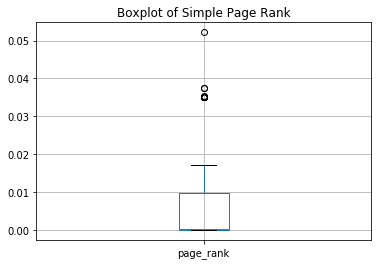

In [18]:
DF.boxplot(column='page_rank')
plt.title("Boxplot of Simple Page Rank");

In [19]:
DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)

title  outDegree  degree  in_degree  \
5                       NBC         39      87         48   
78      Last Comic Standing         19      20          1   
63   Better Late Than Never         19      20          1   
31     America's Got Talent         20      38         18   
16              Titan Games         18      33         15   
25                Making It         18      33         15   
37   American Ninja Warrior         18      34         16   
132                Songland         18      32         14   

     betweenness_centrality  in_degree_centrality  page_rank  subscribers  \
5                  0.126977              0.301887   0.052177       726000   
78                 0.000418              0.006289   0.037509        19800   
63                 0.000450              0.006289   0.037509        12000   
31                 0.023101              0.113208   0.035276     17300000   
16                 0.000450              0.094340   0.035110       117000   
25                 0.000450              0.094340   0.035110        24100   
37                 0.039155              0.100629   0.035110       651000   
132                0.000000              0.088050   0.035110       169000   

          views                        id  
5      62770351  UCccjdJEay2hpb5scz61zY6Q  
78            0  UCUG6rn3QMETve9cjGLtDLxw  
63      1052327  UCqfhoZOoNt2ZpsDBnLAAW4Q  
31   3559455210  UCT2X19JJaJGUN7mrYuImANQ  
16     18377621  UC8F-JB5ucgmXBEiSpurWb3w  
25      1676826  UCnD5lTlF3_tMTs5br5LjXXg  
37    211912626  UC0PEAMcRK7Mnn2G1bCBXOWQ  
132    17637535  UCn-n9rB_JINCyukqH8aflcg

In [20]:
sorted_pgrank_list = list(DF[FEATURES].sort_values(
    'page_rank', ascending=False).head(8)['id'])

Lets take a look at these channels listed on the graph

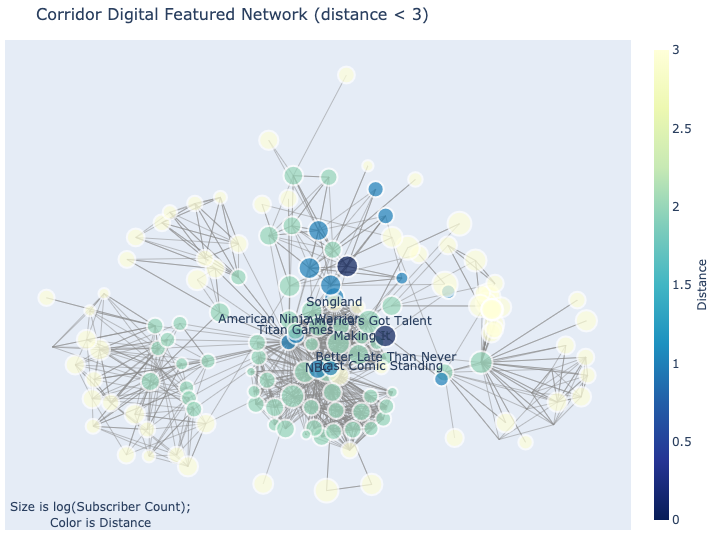

In [35]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital Featured Network (distance < 3)',
                            display_list=sorted_pgrank_list)
fig

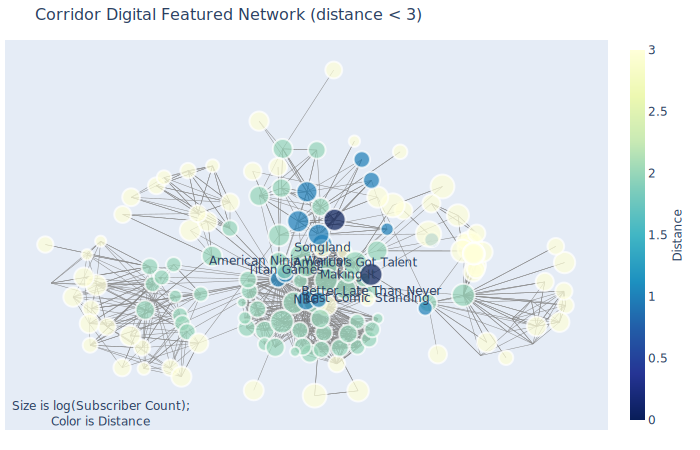

In [36]:
fig.show('svg')

### Sort channels by betweenness centrality.

Betweenness centrality is a measure of connectivity for a node in a network. A higher betweenness centrality implies that the node is a critical pathway for other nodes to connect across the graph.

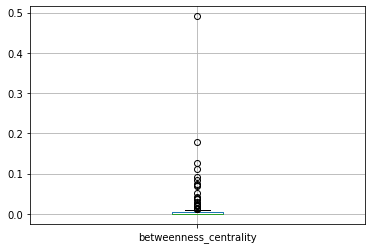

In [22]:
DF.boxplot(column='betweenness_centrality');

In [23]:
DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)

title  outDegree  degree  in_degree  betweenness_centrality  \
12              Peacock         22      82         60                0.490607   
39         Peacock Kids         32      48         16                0.178247   
5                   NBC         39      87         48                0.126977   
28   Universal Pictures          6      11          5                0.112775   
47           Peacock jr          7      15          8                0.091490   
79       Top Chef World          3      25         22                0.083848   
111        Illumination          1       4          3                0.074516   
6                 TODAY          7      17         10                0.071226   

     in_degree_centrality     page_rank  subscribers       views  \
12               0.377358  6.126308e-03        76800    15833709   
39               0.100629  2.097559e-07      7780000  5519195732   
5                0.301887  5.217746e-02       726000    62770351   
28               0.031447  4.245687e-04      3560000  2283414741   
47               0.050314  2.021899e-06       288000   270510811   
79               0.138365  4.585629e-04            0      196439   
111              0.018868  2.900276e-05      2100000  1553396331   
6                0.062893  5.361514e-03      2430000  1699831071   

                           id  
12   UCPgMAS8woHJ_o_OZdTR7kcQ  
39   UCY26xU0-avwTJ6F6TzUZVEw  
5    UCccjdJEay2hpb5scz61zY6Q  
28   UCq0OueAsdxH6b8nyAspwViw  
47   UCKtfozhWfwvXUTnR7PV3t5g  
79   UCzbq2-fIG666CtetQAxiyww  
111  UCq7OHvWO6Z3u-LztFdrcU-g  
6    UChDKyKQ59fYz3JO2fl0Z6sg

In [24]:
sorted_btwn_list = list(DF[FEATURES].sort_values(
    'betweenness_centrality', ascending=False).head(8)['id'])

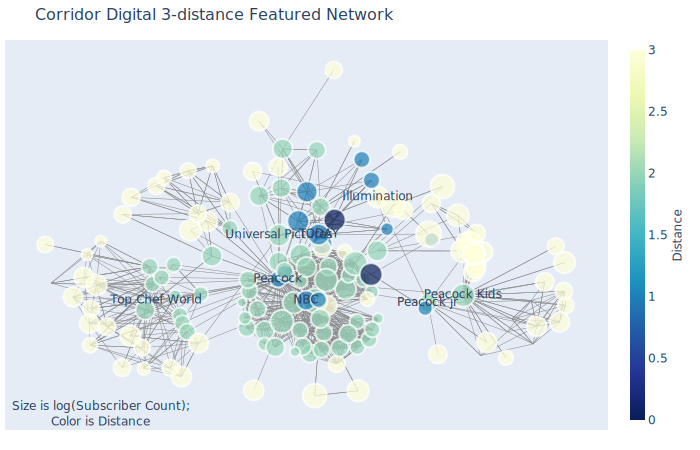

In [25]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_btwn_list)
fig
fig.show('svg')

### Sort channels by in_degree centrality.

In degree centrality is a measure of a nodes importance as a reference from other channels. A high in degree centrality value implies that the node is highly referenced by other channels within this network.

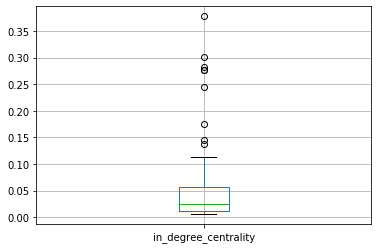

In [26]:
DF.boxplot(column='in_degree_centrality');

In [27]:
DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)

title  outDegree  degree  in_degree  \
12                                  Peacock         22      82         60   
5                                       NBC         39      87         48   
51   The Tonight Show Starring Jimmy Fallon          8      53         45   
67           A Little Late With Lilly Singh          8      52         44   
61              Late Night with Seth Meyers          9      53         44   
107                 The Kelly Clarkson Show          5      43         39   
26                      Saturday Night Live          6      34         28   
32            Zoey's Extraordinary Playlist         15      38         23   

     betweenness_centrality  in_degree_centrality  page_rank  subscribers  \
12                 0.490607              0.377358   0.006126        76800   
5                  0.126977              0.301887   0.052177       726000   
51                 0.015372              0.283019   0.011620     25400000   
67                 0.023208              0.276730   0.006369       470000   
61                 0.015824              0.276730   0.013715      3840000   
107                0.069421              0.245283   0.002515      1150000   
26                 0.009955              0.176101   0.006149     10400000   
32                 0.005249              0.144654   0.015178        86400   

           views                        id  
12      15833709  UCPgMAS8woHJ_o_OZdTR7kcQ  
5       62770351  UCccjdJEay2hpb5scz61zY6Q  
51   12752561131  UC8-Th83bH_thdKZDJCrn88g  
67      56238781  UC2gzy_aI-luPtEpL-GzQP6w  
61    1957688173  UCVTyTA7-g9nopHeHbeuvpRA  
107    166329110  UCmSQ47G2NHhcjRAm9Px6R3g  
26    9438732517  UCqFzWxSCi39LnW1JKFR3efg  
32      17260901  UCafnKR1-5Xd06avwkrEB-fA

Lets also look at the distribution of in degree centrality values.

In [28]:
sorted_indeg_list = list(DF[FEATURES].sort_values(
    'in_degree_centrality', ascending=False).head(8)['id'])

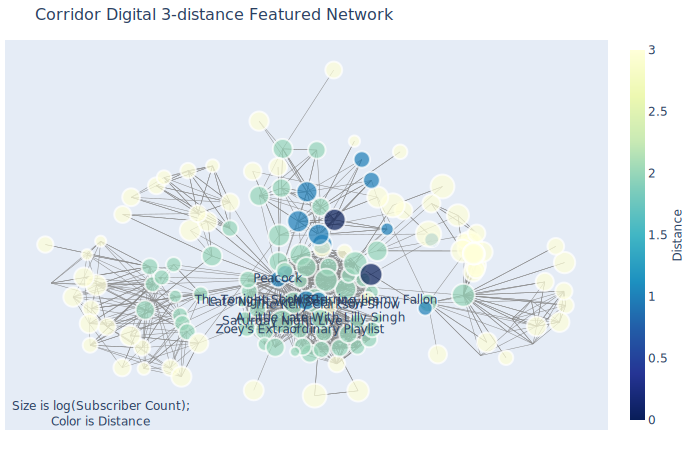

In [29]:
fig = network_graphs.plotly_network_graph(G, 
                              color_setting="Distance", 
                              title='Corridor Digital 3-distance Featured Network',
                            display_list=sorted_indeg_list)
fig.show('svg')

## Strongly Connected Components

Since this graph is a directional graph, and not all references exist in both directions. It is possible to travel through the graph of channels and not be able to return. 

Strongly connected components are portions of the graph that allows you to return to all other nodes in the graph.

In [30]:
# Create a list of strongly connected components
scc_list = [scc for scc in nx.strongly_connected_components(G)]

# Grab the largest strongly connected component
largest_scc_index = [i for i,cn in enumerate(scc_list) if len(cn) == max([len(cnn) for cnn in scc_list])][0]

# Graph out the subgraph for the largest subset of strongly connected components
H = G.subgraph(list(scc_list[largest_scc_index]))

Plot of our subgraph of strongly connected components

In [31]:
#network_graphs.graph_nx_graph(H)
fig = network_graphs.plotly_network_graph(H, 
                                          'Distance', 
                                          title='Strongly Connected Subgraph of Corridor Digital')

Here we see that the majority of the bottom left of the graph is excluded. Meaning while there were references going from the Corridor community to Rooster Teeth, Slow Mo Guys, Hulu, and etc. There did not exist a path referencing anyone in the Corridor community (at least within a distance of three from Corridor), completely separating the graph.

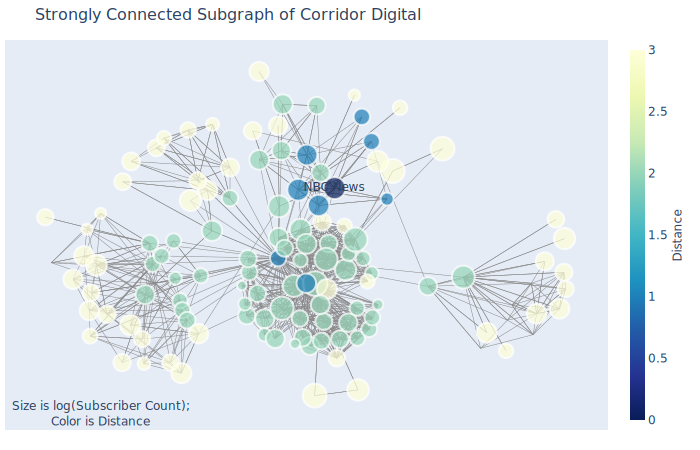

In [32]:
fig.show('svg')

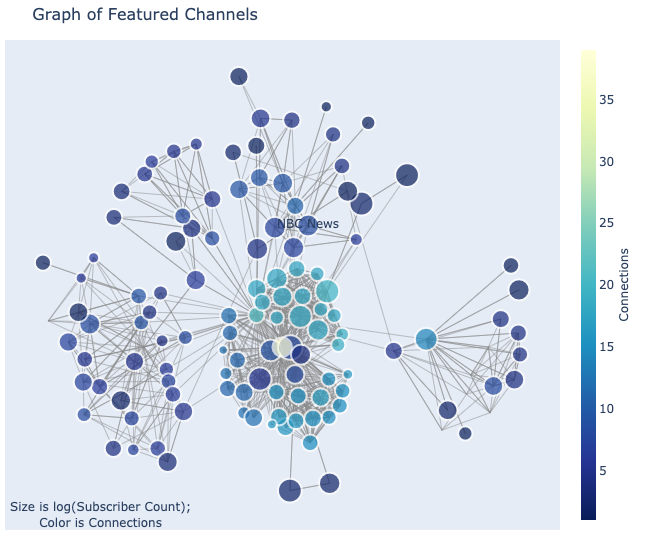

In [33]:
fig = network_graphs.plotly_network_graph(H, 'Connections')
fig

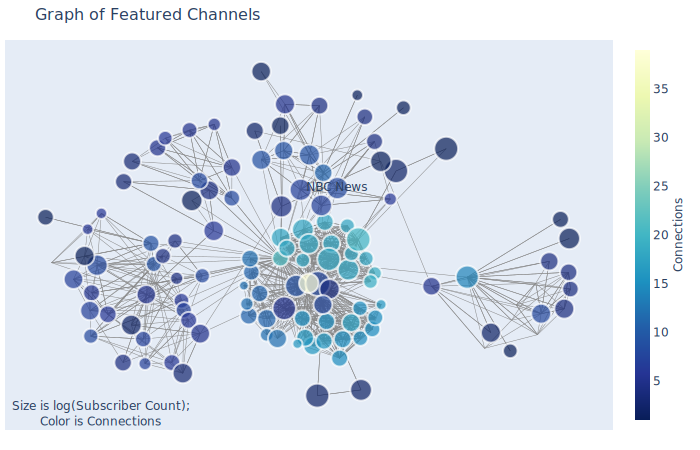

In [34]:
fig.show('svg')